In [1]:
from google.colab import drive

drive.mount('/content/drive')

%cd drive/MyDrive/Colab Notebooks
#! ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00


In [ ]:
# !pip install transformers

In [ ]:
# !pip install transformers[torch]

In [ ]:
# import accelerate

In [3]:
import torch

print("Is cuda available?", torch.cuda.is_available())

print("Is cuDNN version:", torch.backends.cudnn.version())

print("cuDNN enabled? ", torch.backends.cudnn.enabled)

print("Device count?", torch.cuda.device_count())

print("Current device?", torch.cuda.current_device())

print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))

x = torch.rand(5, 3)
print(x)

Is cuda available? True
Is cuDNN version: 8700
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  Tesla T4
tensor([[0.0139, 0.7237, 0.1520],
        [0.4261, 0.9356, 0.6661],
        [0.0751, 0.1580, 0.2904],
        [0.9204, 0.8040, 0.3913],
        [0.1930, 0.3040, 0.2730]])


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertModel, DistilBertTokenizer
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

In [ ]:
# Setting up the device for GPU usage
# from torch import cuda

# device = 'cuda' if cuda.is_available() else 'cpu'

**Load and Preprocess data**

In [5]:
df = pd.read_csv('data_model.csv').sample(frac=1)

In [11]:
df.shape

(8722, 34)

In [12]:
df['label'] = df['label'].astype('int')

In [17]:
df_trainA = df.sample(frac=0.8, random_state=44)
df_val_testA = df.drop(df_trainA.index).reset_index(drop=True)
df_valA = df_val_testA.sample(frac=0.5, random_state=44)
df_testA = df_val_testA.drop(df_valA.index).reset_index(drop=True)
df_trainA = df_trainA.reset_index(drop=True)
df_valA = df_valA.reset_index(drop=True)

In [18]:
print(df_trainA.shape, df_valA.shape, df_testA.shape)

(6978, 34) (872, 34) (872, 34)


In [19]:
df_trainA.head()

,id,session_log_id,useraccount_id,subject_id,counter,class_id,school_id,is_parent_post,reply_to_post_id,karma_awarded_id,...,ts_modified,TOXICITY,IDENTITY_ATTACK,INSULT,PROFANITY,THREAT,SEXUALLY_EXPLICIT,token_num,safety_score,type
0,3236211,39390258,3248851,21,97668,NaN,12975,0,3236133,NaN,...,1/28/2021 23:51,0.018095,0.005032,0.008273,0.015352,0.008557,0.013624,13,0.988511,safe
1,1245380,4498540,1224718,1,1189628,NaN,12680,0,1245335,NaN,...,3/4/2016 22:30,0.507899,0.039972,0.152370,0.254586,0.560658,0.143173,48,0.723557,marginal
2,683350,1836158,2459073,1,664205,NaN,14600,0,683345,NaN,...,4/1/2015 23:34,0.012880,0.003552,0.007855,0.013747,0.006829,0.009967,11,0.990862,safe
3,1759886,8112424,2736899,1,1617592,NaN,14204,0,1759821,NaN,...,11/30/2016 18:47,0.799855,0.013747,0.777521,0.379940,0.008376,0.016278,10,0.667381,unsafe
4,2455672,16539299,3350806,1,2107696,NaN,15248,0,2455616,174759.0,...,3/4/2018 20:51,0.008011,0.001202,0.006905,0.010228,0.006188,0.004128,15,0.993890,safe


In [20]:
df_train = df_trainA[['id', 'comment_text', 'label', 'TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT', 'SEXUALLY_EXPLICIT']]
df_val = df_valA[['id', 'comment_text', 'label', 'TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT', 'SEXUALLY_EXPLICIT']]
df_train.head()

,id,comment_text,label,TOXICITY,IDENTITY_ATTACK,INSULT,PROFANITY,THREAT,SEXUALLY_EXPLICIT
0,3236211,I divided 530 from both sides but not sure wha...,0,0.018095,0.005032,0.008273,0.015352,0.008557,0.013624
1,1245380,well my brother was playing football with his ...,1,0.507899,0.039972,0.152370,0.254586,0.560658,0.143173
2,683350,"Yes, they are the graphs that go along with Qu...",0,0.012880,0.003552,0.007855,0.013747,0.006829,0.009967
3,1759886,How? I said I'm tired of your stupid comments.,1,0.799855,0.013747,0.777521,0.379940,0.008376,0.016278
4,2455672,What you have to do is this:\n\n(Total cost of...,0,0.008011,0.001202,0.006905,0.010228,0.006188,0.004128


In [21]:
# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
print(model.classifier.parameters)

<bound method Module.parameters of Linear(in_features=768, out_features=2, bias=True)>


In [23]:
X_train_tokenized = tokenizer(list(df_train["comment_text"]), padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(list(df_val["comment_text"]), padding=True, truncation=True, max_length=512)

In [24]:
y_train = list(df_train["label"])
y_val = list(df_val["label"])

In [25]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [26]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

**Fine-tune pretained model**

In [27]:
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    optim="torch.optim.AdamW",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [30]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    seed=0,
    logging_steps=20,
    save_steps=20,
    optim="adamw_torch",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [31]:
# Train pre-trained model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,0.144400,0.459302,0.866972,0.870466,0.835821,0.852792
40,0.179100,0.477076,0.901376,0.915789,0.865672,0.890026
60,0.369200,0.297709,0.919725,0.899038,0.930348,0.914425
80,0.199000,0.250077,0.943807,0.973190,0.902985,0.936774
100,0.420700,0.183889,0.948394,0.945137,0.942786,0.943960
120,0.162800,0.269605,0.935780,0.913876,0.950249,0.931707
140,0.291400,0.276606,0.940367,0.986111,0.883085,0.931759
160,0.321900,0.215157,0.946101,0.978437,0.902985,0.939198
180,0.214600,0.270208,0.936927,0.983287,0.878109,0.927727
200,0.178500,0.246869,0.939220,0.983380,0.883085,0.930537


RuntimeError: ignored

**Predict**

In [ ]:
# Load test data
test_data = pd.read_csv("test.csv")
X_test = list(test_data["review"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
model_path = "output/checkpoint-50000"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

**SHAP**

In [33]:
# Load trained model
model_path = "output/checkpoint-80"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

OSError: ignored

Setting Up the Model Pipeline

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
from transformers import ZeroShotClassificationPipeline
from typing import Union, List
import shap

In [ ]:
from typing import Union

In [ ]:
# Create a custom pipeline that only requires the text parameter
# for the __call__ method and provides a method to set the labels
class ZeroShotModelPipeline(ZeroShotClassificationPipeline):
  def _parse_labels(self, labels):
        if isinstance(labels, str):
            labels = [label.strip() for label in labels.split(",")]
        return labels

    # Overwrite the __call__ method
  def __call__(self, *args):
        out = super().__call__(args[0], self.set_labels)[0]

        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]

  def set_labels(self, labels: Union[str,List[str]]):
        self.set_labels = labels

In [ ]:
def score_and_visualize(text, shap_values):
    prediction = pipe(text)
    print(f"Model predictions are: {prediction}")
    shap.plots.text(shap_values)

In [ ]:
# Setting up the inference text data and the corresponding labels
text = ["tyler shut up before i smack u in your head"]
labels = ["safe","unsafe"]

In [ ]:
text =["can someone kill me please. i hate life and i cant hang myself:("]
labels = ["safe", "unsafe"]

In [ ]:
# Assign the labels for the classification model
model.config.label2id.update({v:k for k,v in enumerate(labels)})
model.config.id2label.update({k:v for k,v in enumerate(labels)})

pipe = ZeroShotModelPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

# Setting the on-the-fly labels to the model pipeline
pipe.set_labels(labels)

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


SHAP for explainability

In [ ]:
# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values = explainer(text)

score_and_visualize(text, shap_values)

  0%|          | 0/132 [00:00<?, ?it/s]

Partition explainer: 2it [00:27, 27.32s/it]               


Model predictions are: [[{'label': 'safe', 'score': 0.5011624097824097}, {'label': 'unsafe', 'score': 0.49883759021759033}]]


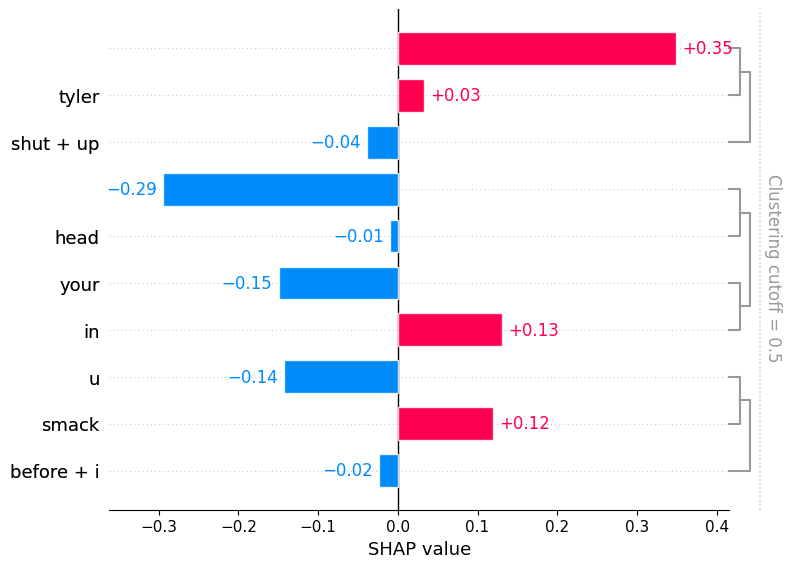

In [ ]:
# Let's visualize the feature importance towards the outcome - unsafe
shap.plots.bar(shap_values[0,:,'unsafe'])